# ResNet50

### Importing Library and Models [1]

In [1]:
from __future__ import print_function
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Input, AveragePooling2D, Dropout
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.metrics import f1_score
from keras.layers.core import Dense, Activation, Flatten, Dropout
import math
from keras import optimizers
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.regularizers import l2
import codecs
import sklearn.metrics as sklm
from keras.utils.np_utils import to_categorical
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
import sys

import os
import cv2
import numpy as np
import scipy.misc as sm

Using TensorFlow backend.


### Loading the Data [1]

In [2]:
#loading the data from the folder
ls1=os.listdir('color')

if '.DS_Store' in ls1:
    ls1.remove('.DS_Store')

print(ls1)

dic1={}
count=0

#taking the count of the files
for idx,i in enumerate(ls1):
    dic1[i]=idx
    ls2=os.listdir('color/'+i)
    if '.DS_Store' in ls2:
        ls2.remove('.DS_Store')
    for j in ls2:
        count=count+1
        
print("Reach 1 \n")
ls1=os.listdir('color')
if '.DS_Store' in ls1:
    ls1.remove('.DS_Store')

dic1={}
X=np.zeros((count,256,256,3))
Y=np.zeros((count,1))
vap=0

#Putting images and labels in X and Y
for idx,i in enumerate(ls1):
    dic1[i]=idx
    ls2=os.listdir('color/'+i)
    if '.DS_Store' in ls2:
        ls2.remove('.DS_Store')
    for idx2,j in enumerate(ls2):
        X[vap, :, :, :]=cv2.imread('color/'+i+'/'+j)
        Y[vap,0]=idx
        vap=vap+1

['Apple___Cedar_apple_rust', 'Apple___Apple_scab', 'Apple___Black_rot', 'Apple___healthy']
Reach 1 



### Defining Metric Functions [1]

In [3]:
class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.confusion = []
        self.precision = []
        self.recall = []
        self.f1s = []

    def on_epoch_end(self, epoch, logs={}):
        score = np.asarray(self.model.predict(self.validation_data[0]))
        predict = np.round(np.asarray(self.model.predict(self.validation_data[0])))
        targ = self.validation_data[1]

        self.f1s.append(sklm.f1_score(targ, predict,average='micro'))
        self.confusion.append(sklm.confusion_matrix(targ.argmax(axis=1),predict.argmax(axis=1)))

        return

### Setting Hyper-parameters [1]

In [4]:
#Hyperparameters
batch_size = 64
num_classes = len(dic1)
epochs = 30

# input image dimensions
img_rows, img_cols = 256, 256
h = 299
w = 299
ch = 3
print("Reach 2.5 \n")
#tensor. will receive cifar10 images as input, gets passed to resize_images
img_placeholder = tf.placeholder("uint8", (None, 256, 256, 3))

#tensor. resized images. gets passed into Session()
resize_op = tf.image.resize_images(img_placeholder, (h, w), method=0)

Reach 2.5 



### Defining Pre-processing Images function[1] and the ResNet50 Model [1]

In [5]:
# create a generator for batch processing
# this gen is written as if you could run through ALL of the data
# AWS instance doesn't have enough memory to hold the entire training bottleneck in memory
# so we will call for 10000 samples when we call it
def gen(session, data, labels, batch_size):
    def _f():
        start = 0
        end = start + batch_size
        n = data.shape[0]
        max_iter = math.ceil(n/batch_size)
        while True:
            # run takes in a tensor/function and performs it.
            # almost always, that function will take a Tensor as input
            # when run is called, it takes a feed_dict param which translates
            # Tensors into actual data/integers/floats/etc
            # this is so you can write a network and only have to change the
            # data being passed in one place instead of everywhere
            for i in range(0,max_iter):
                # X_batch is resized
                X_batch = session.run(resize_op, {img_placeholder: data[start:end]})
                # X_batch is normalized
                X_batch = preprocess_input(X_batch)
                y_batch = labels[start:end]
                start += batch_size
                end += batch_size

                yield (X_batch, y_batch)

    return _f

def create_model_resnet():
    #create input tensor
    input_tensor = Input(shape=(h, w, ch))
    #set the model
    model = ResNet50(input_tensor=input_tensor, include_top=False)
    return model
print("Reach 2.8 \n")

Reach 2.8 



### Splitting the data into Train and Test [1]

In [6]:
X_train1, X_val1, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=0,shuffle=True)
print("Reach 3 \n")
print(X_train1.shape)
print(y_train.shape)

Reach 3 

(2219, 256, 256, 3)
(2219, 1)


### Training the model on the dataset [1]

In [7]:
with tf.Session() as sess:
    K.set_session(sess)
    K.set_learning_phase(1)

    model = create_model_resnet()                         #call the model function

    train_gen = gen(sess, X_train1, y_train, batch_size)  #pre-process the train data
    
    X_train = model.predict_generator(train_gen(), 64)    #implement model on train data
    print("conv to train list complete")
    

    val_gen = gen(sess, X_val1, y_val, batch_size)        #pre-process the test data
    
    X_val = model.predict_generator(val_gen(), 64)        #implement model on test data
    print("conv to val list complete")
    
print("Reach 4 \n")

#set the target labels according to the number of classess
y_train = to_categorical(y_train, num_classes= num_classes)
y_val = to_categorical(y_val,num_classes = num_classes)

print("Reach 4 end \n")

/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


conv to train list complete
conv to val list complete
Reach 4 

Reach 4 end 



### Creating the Final Layer [1]

In [8]:
# Adding final layer
input_shape = X_train.shape[1:]
inp = Input(shape=input_shape)
x = Flatten()(inp)
x = Dense(num_classes, activation='softmax')(x)
model = Model(inp, x)
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

metrics = Metrics()

### Results [1]

Train on 2219 samples, validate on 952 samples
Epoch 1/30
2219/2219 [==============================] - 8s 3ms/step - loss: 7.4844 - acc: 0.5155 - val_loss: 8.0896 - val_acc: 0.4979
Epoch 2/30
2219/2219 [==============================] - 7s 3ms/step - loss: 7.1726 - acc: 0.5507 - val_loss: 5.1239 - val_acc: 0.6754
Epoch 3/30
2219/2219 [==============================] - 7s 3ms/step - loss: 4.6645 - acc: 0.7066 - val_loss: 4.8438 - val_acc: 0.6964
Epoch 4/30
2219/2219 [==============================] - 7s 3ms/step - loss: 4.5696 - acc: 0.7156 - val_loss: 4.7929 - val_acc: 0.7006
Epoch 5/30
2219/2219 [==============================] - 7s 3ms/step - loss: 4.5614 - acc: 0.7165 - val_loss: 4.8009 - val_acc: 0.7006
Epoch 6/30
2219/2219 [==============================] - 7s 3ms/step - loss: 4.5528 - acc: 0.7170 - val_loss: 4.8068 - val_acc: 0.6996
Epoch 7/30
2219/2219 [==============================] - 7s 3ms/step - loss: 4.5474 - acc: 0.7174 - val_loss: 4.7998 - val_acc: 0.6996
Epoch 8/30
2219

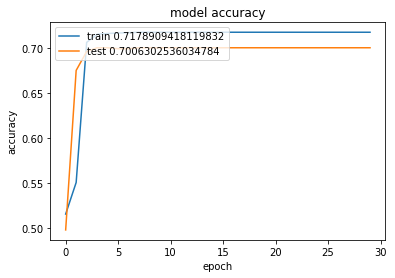

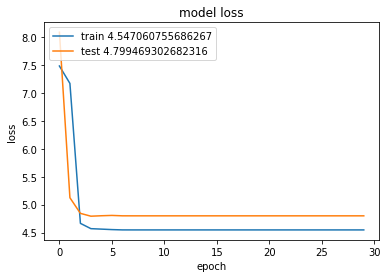

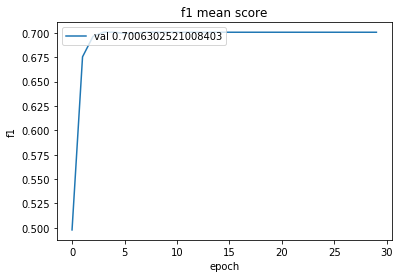

[[  0   0  35  37]
 [  0   0  38 170]
 [  0   0 195   3]
 [  0   0   2 472]]
Reach End 



In [9]:
with tf.Session() as sess:
    # fetch session so Keras API can work
    K.set_session(sess)
    K.set_learning_phase(1)
    history =model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                       validation_data=(X_val, y_val), shuffle=True, verbose=1,callbacks=[metrics] )
    print(metrics.f1s)

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    print(history.history['acc'])
    
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train ' + str(acc[-1]), 'test ' + str(val_acc[-1])], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train ' + str(loss[-1]), 'test ' + str(val_loss[-1])], loc='upper left')
    plt.show()

    # # summarize history for f1
    plt.plot(metrics.f1s)
    # plt.plot(history.history['val_f1'])
    plt.title('f1 mean score')
    plt.ylabel('f1')
    plt.xlabel('epoch')
    plt.legend(['val ' + str(metrics.f1s[-1])], loc='upper left')
    plt.show()

    print(metrics.confusion[-1])
    
print("Reach End \n")

### References

1. https://github.com/YashG2002/Tomato-Disease-Detection

### License

MIT License

Copyright (c) 2018 Yash Gupta

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.